In [36]:
import warnings
warnings.filterwarnings("ignore")

from typing import Optional
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, load_model
import keras
import keras_tuner

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,  KFold

In [37]:
# helper functions
def plot_images(imgs1, imgs2, labels=['', ''], title = ''):

    n_images = imgs1.shape[0]
    assert imgs1.shape[0] == imgs2.shape[0], "number of imgs 1 and 2 are not equal"

    fig, axes = plt.subplots(n_images, 2)

    for i in range(n_images):
        im = axes[i, 0].imshow(imgs1[i], cmap='seismic')
        axes[i, 0].axis('off')
        fig.colorbar(im, ax=axes[i, 0])
        axes[i, 0].set_title(labels[0])

        im = axes[i, 1].imshow(imgs2[i], cmap='seismic')
        axes[i, 1].axis('off')
        fig.colorbar(im, ax=axes[i, 1])
        axes[i, 1].set_title(labels[1])
    # plt.tight_layout()
    fig.suptitle(title)
    plt.show()
    

Number of training samples:  150
Number of test samples:  150
Minimum and maximum values of X_train: 0.0  -  0.307547269467031
Minimum and maximum values of X_test: 0.0  -  0.43493751210745
Minimum and maximum values of Y_train: 0.0  -  0.526185910637691
Minimum and maximum values of Y_test: 0.0  -  0.528667452358872


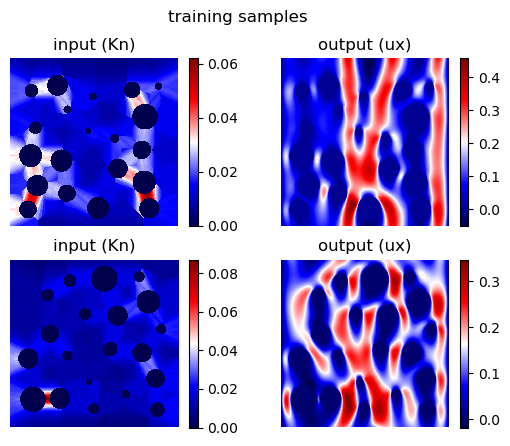

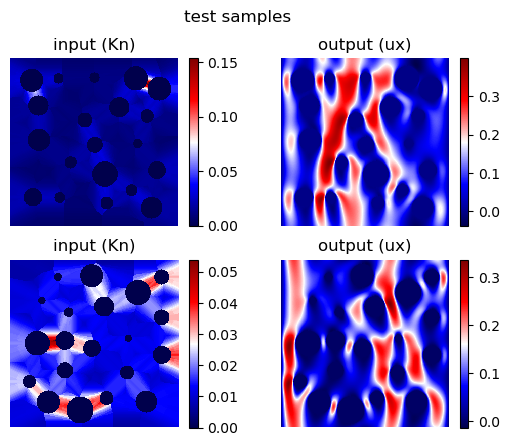

In [38]:
# Load Data
"""
# This part of the code is used only once to load data from txt files and save as npy file
# so that future loading is faster
directory = "../HPO/domain_generation"
input_images = np.zeros((300, 500, 500))
output_images = np.zeros((300, 500, 500))
for i in range(300):
    file_kn = directory + "/d" + str(i+1) + "/Kn.txt"
    file_ux = directory + "/d" + str(i+1) + "/out/UX.txt"
    kn = np.loadtxt(file_kn)
    ux = np.loadtxt(file_ux)
    kn = kn.reshape((500, 500))
    ux = ux.reshape((500, 500))
    input_images[i, :, :] = kn
    output_images[i, :, :] = ux
    print(i)

np.save('input', input_images)
np.save('output', output_images)
"""

X = np.load("input.npy")
Y = np.load("output.npy")

# split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=True, random_state=100)

print("Number of training samples: ", X_train.shape[0])
print("Number of test samples: ", X_test.shape[0])

print("Minimum and maximum values of X_train:", np.min(X_train), " - ", np.max(X_train))
print("Minimum and maximum values of X_test:", np.min(X_test), " - ", np.max(X_test))

print("Minimum and maximum values of Y_train:", np.min(X_train), " - ", np.max(Y_train))
print("Minimum and maximum values of Y_test:", np.min(X_test), " - ", np.max(Y_test))

plot_images(X_train[0:2], Y_train[0:2], labels=['input (Kn)', 'output (ux)'], title='training samples')
plot_images(X_test[0:2], Y_test[0:2], labels=['input (Kn)', 'output (ux)'], title='test samples')


In [14]:
class Preprocessor():
    def __init__(self,  n_x = 15, n_y = 10):
        self.n_x = n_x
        self.n_y = n_y
        self.n_components = self.n_x * self.n_y

        self.pcaX = PCA(n_components=self.n_components )
        self.pcaY = PCA(n_components=self.n_components )
        
        self.prePCaMinX = 0
        self.prePCaMinY = 0
        self.posPCaMinX = 0
        self.posPCaMinY = 0
        
        self.prePCaMaxX = 0
        self.prePCaMaxY = 0
        self.posPCaMaxX = 0
        self.posPCaMaxY = 0

        self.OriginalNX = 0
        self.OriginalNY = 0

    def fit(self, X, Y):
        self.OriginalNX = X.shape[1]
        self.OriginalNY = X.shape[2]

        # flatten
        X_flat = self.flattenImage(X)
        Y_flat = self.flattenImage(Y)

        # scale between 0 and 1
        self.prePCaMinX = np.min(X_flat)
        self.prePCaMinY = np.min(Y_flat)
        self.prePCaMaxX = np.max(X_flat)
        self.prePCaMaxY = np.max(Y_flat)

        # this scaling is necessary for fitting PCA
        X_scaled = (X_flat - self.prePCaMinX) / (self.prePCaMaxX - self.prePCaMinX)
        Y_scaled = (Y_flat - self.prePCaMinY) / (self.prePCaMaxY - self.prePCaMinY)

        # apply PCA
        self.pcaX.fit(X_scaled)
        self.pcaY.fit(Y_scaled)
        # apply PCA
        X_scaled = self.pcaX.transform(X_scaled)
        Y_scaled = self.pcaY.transform(Y_scaled)

        # scale between 0 and 1
        self.posPCaMinX = np.min(X_scaled)
        self.posPCaMinY = np.min(Y_scaled)
        self.posPCaMaxX = np.max(X_scaled)
        self.posPCaMaxY = np.max(Y_scaled)
        return self

    def transform(self, X, Y):
        # flatten
        X_flat = self.flattenImage(X)
        Y_flat = self.flattenImage(Y)

        # scale between 0 and 1
        X_scaled = (X_flat - self.prePCaMinX) / (self.prePCaMaxX - self.prePCaMinX)
        Y_scaled = (Y_flat - self.prePCaMinY) / (self.prePCaMaxY - self.prePCaMinY)
        
        # apply PCA
        X_scaled = self.pcaX.transform(X_scaled)
        Y_scaled = self.pcaY.transform(Y_scaled)

        # scale between 0 and 1
        X_scaled = (X_scaled - self.posPCaMinX) / (self.posPCaMaxX - self.posPCaMinX)
        Y_scaled = (Y_scaled - self.posPCaMinY) / (self.posPCaMaxY - self.posPCaMinY)

        # reshape
        X_scaled = self.flatTo2D(X_scaled, self.n_x, self.n_y)
        Y_scaled = self.flatTo2D(Y_scaled, self.n_x, self.n_y)

        return X_scaled, Y_scaled

    def inverse_transform(self, X, Y):
        # flatten
        X_flat = self.flattenImage(X)
        Y_flat = self.flattenImage(Y)

        # inverse scale
        X_scaled = X_flat * (self.posPCaMaxX - self.posPCaMinX) + self.posPCaMinX
        Y_scaled = Y_flat * (self.posPCaMaxY - self.posPCaMinY) + self.posPCaMinY

        # inverse PCA
        X_scaled = self.pcaX.inverse_transform(X_scaled)
        Y_scaled = self.pcaY.inverse_transform(Y_scaled)
        
        # inverse scale
        X_scaled = X_scaled * (self.prePCaMaxX - self.prePCaMinX) + self.prePCaMinX
        Y_scaled = Y_scaled * (self.prePCaMaxY - self.prePCaMinY) + self.prePCaMinY

        # reshape
        X_scaled = self.flatTo2D(X_scaled, self.OriginalNX, self.OriginalNY)
        Y_scaled = self.flatTo2D(Y_scaled, self.OriginalNX, self.OriginalNY)

        return X_scaled, Y_scaled

    @staticmethod    
    def flattenImage(X):
        X_flat = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        return X_flat
    
    @staticmethod
    def flatTo2D(X, n_x, n_y):
        X = X.reshape((X.shape[0], n_x, n_y))
        return X
        

Input, output image shape: (150, 15, 10)


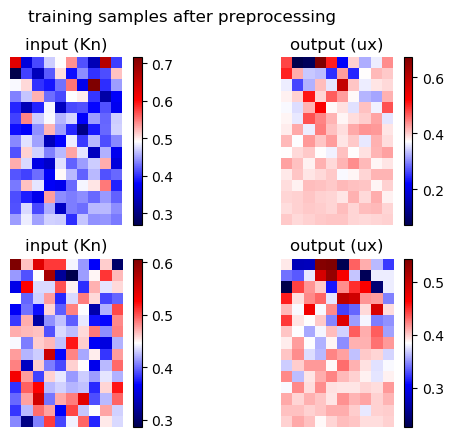

In [15]:
# apply preprocessing on training data
prep_train = Preprocessor(15, 10)
prep_train = prep_train.fit(X_train, Y_train)
x_train, y_train= prep_train.transform(X_train, Y_train)

print("Input, output image shape:" , x_train.shape)
plot_images(x_train[0:2], y_train[0:2], labels=['input (Kn)', 'output (ux)'], title='training samples after preprocessing')

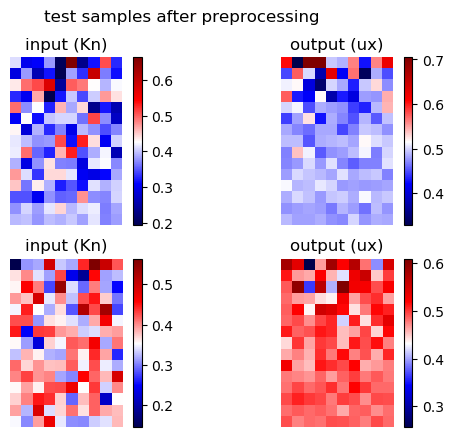

In [16]:
prep_test = Preprocessor(15, 10)
prep_test = prep_test.fit(X_test, Y_test)
x_test, y_test= prep_test.transform(X_test, Y_test)

plot_images(x_test[0:2], y_test[0:2], labels=['input (Kn)', 'output (ux)'], title='test samples after preprocessing')

Sum of absolute difference in X_train reconstruction:  9.87735380914853e-10
Sum of absolute difference in Y_train reconstruction:  1.1604159076093117e-08


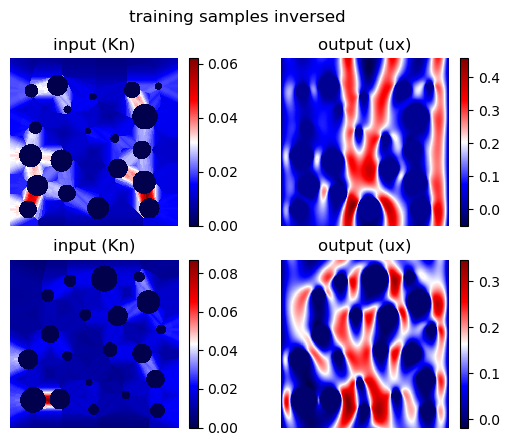

In [17]:
# test inverse preprocessing on training data
x_train_inv, y_train_inv = prep_train.inverse_transform(x_train, y_train)

# calculate reconstruction error
abs_errroX_train = np.sum(np.abs(X_train - x_train_inv))
abs_errroY_train = np.sum(np.abs(Y_train - y_train_inv))

print("Sum of absolute difference in X_train reconstruction: ", abs_errroX_train)
print("Sum of absolute difference in Y_train reconstruction: ", abs_errroY_train)

plot_images(x_train_inv[0:2], y_train_inv[0:2], labels=['input (Kn)', 'output (ux)'], title='training samples inversed')

Sum of absolute difference in X_test reconstruction:  1.018579965583668e-09
Sum of absolute difference in Y_test reconstruction:  1.0067834651649804e-08


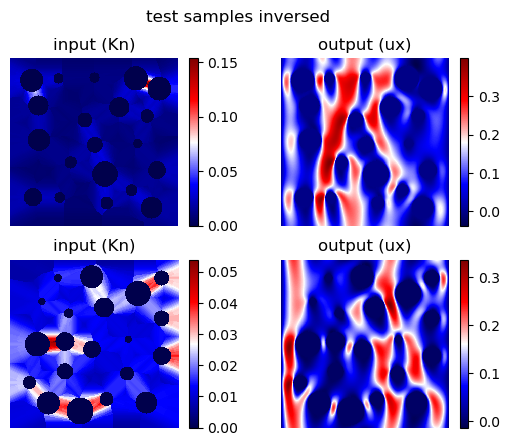

In [18]:
# test inverse preprocessing on test data
x_test_inv, y_test_inv = prep_test.inverse_transform(x_test, y_test)

# calculate reconstruction error
abs_errroX_test = np.sum(np.abs(X_test - x_test_inv))
abs_errroY_test = np.sum(np.abs(Y_test - y_test_inv))

print("Sum of absolute difference in X_test reconstruction: ", abs_errroX_test)
print("Sum of absolute difference in Y_test reconstruction: ", abs_errroY_test)

plot_images(x_test_inv[0:2], y_test_inv[0:2], labels=['input (Kn)', 'output (ux)'], title='test samples inversed')

In [28]:
def build_cnn_model(hp, input_shape=(15, 10, 1)):
        # the search space includes
        # activation functions: 'relu', 'sigmoid', 'tanh', 'softmax'
        # loss functions: 'mean_squared_error', 'mean_absolute_error',  'mean_absolute_percentage_error','mean_squared_logarithmic_error'
        # number of kernels in hidden layers: 
        # learning rate: sampling between 1e-4 amd 1e-2 linearly spaced

        with tf.device('/cpu:0'):
            model = Sequential()

            # Convolutional layers
            model.add(Conv2D(hp.Choice('units', [8, 16, 32]), (3, 2), 
                            activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), input_shape=input_shape, padding='same'))
            model.add(MaxPooling2D((1, 1), padding='same'))

            model.add(Conv2D(hp.Choice('units', [8, 16, 32]), (3, 2), 
                            activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), padding='same'))
            model.add(MaxPooling2D((3, 2), padding='same'))

            model.add(Conv2D(hp.Choice('units', [8, 16, 32]), (3, 2), 
                            activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), padding='same'))
            model.add(MaxPooling2D((1, 1), padding='same'))

            # Up-sampling layers
            model.add(Conv2D(hp.Choice('units', [8, 16, 32]), (3, 2),
                            activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), padding='same'))
            model.add(UpSampling2D((1, 1)))

            model.add(Conv2D(hp.Choice('units', [8, 16, 32]), (3, 2), 
                            activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), padding='same'))
            model.add(UpSampling2D((3, 2)))

            model.add(Conv2D(hp.Choice('units', [8, 16, 32]), (3, 2),
                            activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), padding='same'))
            model.add(UpSampling2D((1, 1)))

            # Output layer
            model.add(Conv2D(1, (3, 2), 
                            activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh', 'softmax']), padding='same'))

            opt = keras.optimizers.Adam(learning_rate=hp.Float('lr', min_value = 1e-4, max_value=1e-2, sampling = 'linear'))
            # Compile the model
            model.compile(optimizer=opt,
                        loss=hp.Choice('loss', ['mean_squared_error', 'mean_absolute_error',  'mean_absolute_percentage_error','mean_squared_logarithmic_error']))

        return model 


In [29]:
# Optimization Methods
def Tuner(build_model, x_train, y_train, epochs):
    bo_tuner = keras_tuner.BayesianOptimization(
        hypermodel=build_model,
        objective="val_loss",
        max_trials=100,
        executions_per_trial=1,
        overwrite=True,
        directory="bo_tuner",
        project_name="bo",
    )

    bo_tuner.search(x_train, y_train, epochs=epochs, validation_split = 0.1)
    return  bo_tuner


bo_results = Tuner(build_cnn_model, x_train, y_train, 75)


Trial 100 Complete [00h 00m 12s]
val_loss: 0.1283515989780426

Best val_loss So Far: 0.0013554820325225592
Total elapsed time: 00h 21m 35s


In [44]:
import math

def train_model(model, x_train, y_train, epochs, batch_size, cv_folds = 5):
    n_samples = x_train.shape[0]
    epochs = math.floor(epochs / cv_folds)
    kf = KFold(n_splits=cv_folds)
    loss = []
    val_loss = []
    for iter in range(epochs):
        print(f"Iteration {iter}:")
        for i, (train_index, test_index) in enumerate(kf.split(x_train)):
            print(f"Fold {i}:")
            x = x_train[train_index]
            y = y_train[train_index]
            x_val = x_train[test_index]
            y_val = y_train[test_index]
            h = model.fit(x, y, batch_size=batch_size, epochs=1, verbose=1, validation_data = (x_val, y_val), shuffle=True)
            loss.append(h.history['loss'])
            val_loss.append(h.history['val_loss'])
    return model, loss, val_loss


In [79]:

print(bo_results.results_summary())
best_models = bo_results.get_best_models(3)

# train all 3 models
trained_models = []

losses = []
val_losses = []
for m in range(3):
    model_ = best_models[m]
    model_, loss, val_loss = train_model(model_, x_train, y_train, epochs = 500, batch_size=1, cv_folds = 5)
    losses.append(loss)
    val_losses.append(val_loss)
    trained_models.append(model_)



Results summary
Results in bo_tuner/bo
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 002 summary
Hyperparameters:
units: 16
activation: sigmoid
lr: 0.007117963119696698
loss: mean_squared_logarithmic_error
Score: 0.0013554820325225592

Trial 004 summary
Hyperparameters:
units: 32
activation: relu
lr: 0.0015580227834099901
loss: mean_squared_logarithmic_error
Score: 0.001360208378173411

Trial 008 summary
Hyperparameters:
units: 32
activation: tanh
lr: 0.006192522500429262
loss: mean_squared_logarithmic_error
Score: 0.0013634677743539214

Trial 014 summary
Hyperparameters:
units: 8
activation: tanh
lr: 0.006963656178991442
loss: mean_squared_logarithmic_error
Score: 0.0013687348691746593

Trial 001 summary
Hyperparameters:
units: 16
activation: tanh
lr: 0.0038477699763922826
loss: mean_squared_logarithmic_error
Score: 0.0013776576379314065

Trial 000 summary
Hyperparameters:
units: 16
activation: relu
lr: 0.005996001858144324
loss: mean_absolute_error
Score: 

Model:  0  Absolute error:  0.0024783933235557423
Model:  1  Absolute error:  0.004086278769280319
Model:  2  Absolute error:  1.9615862822486
best model:  2
5/5 [==============================] - 0s 11ms/step


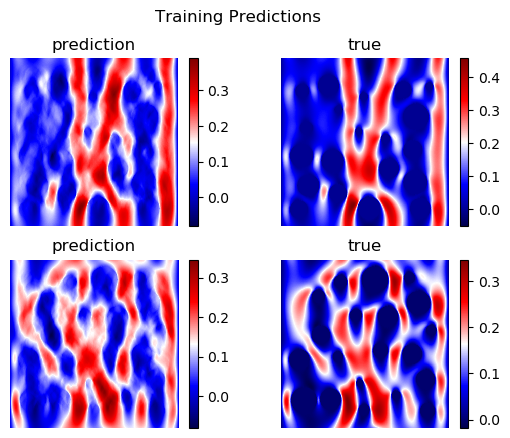

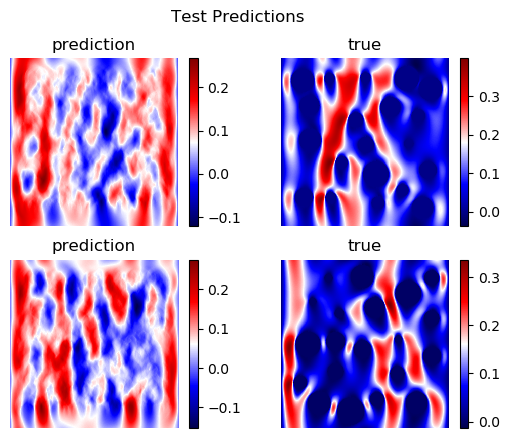

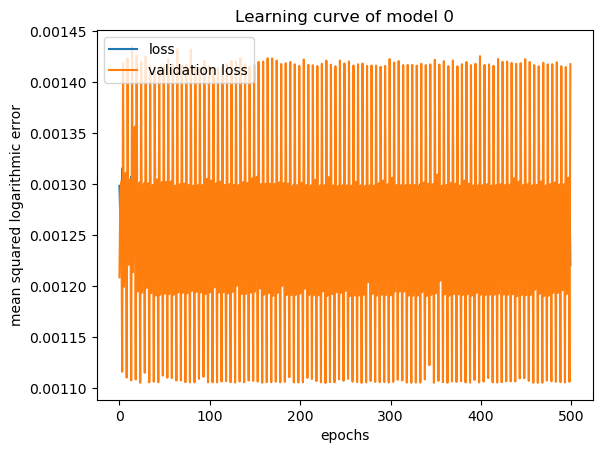

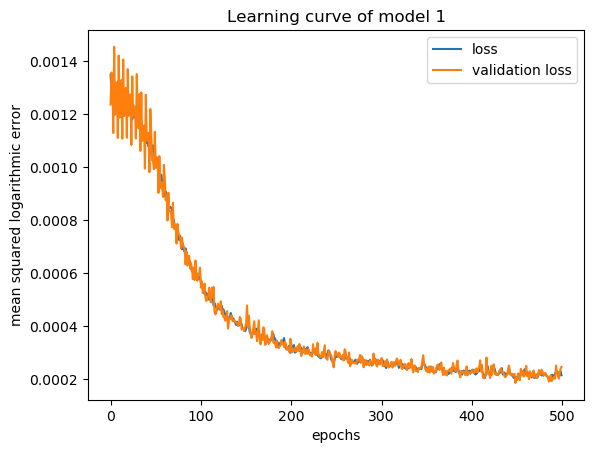

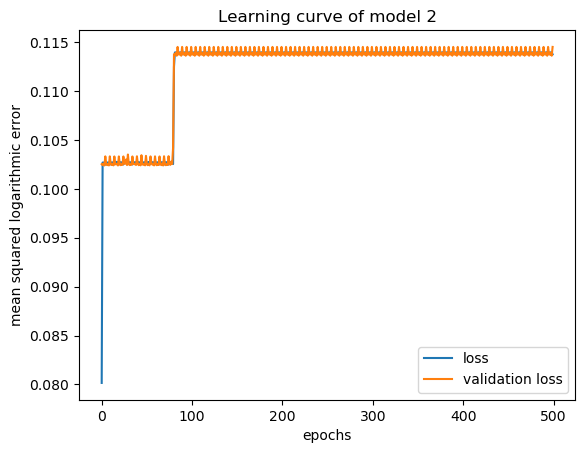

In [80]:
from sklearn.metrics import mean_squared_error

model_errors = []
for m in range(3):
    # evaluate on test data
    y_pred = trained_models[m].predict(x_test, verbose = 0).reshape(150, 15, 10)
    
    # calcuate test score
    err = mean_squared_error(y_pred.reshape((150, 150)), y_train.reshape((150, 150)))
    model_errors.append(err)
    print("Model: ", m, " Absolute error: ", err)


print("best model: ",2)
best_model = trained_models[1]

y_train_pred = best_model.predict(x_train, verbose = 0)
x_train_, y_train_pred_inv = prep_train.inverse_transform(x_train, y_train_pred)

y_test_pred = best_model.predict(x_test)
x_test_, y_test_pred_inv = prep_train.inverse_transform(x_test, y_test_pred)

plot_images(y_train_pred_inv[0:2], y_train_inv[0:2], labels=['prediction', 'true'], title = 'Training Predictions')
plot_images(y_test_pred_inv[0:2], y_test_inv[0:2], labels=['prediction', 'true'], title = 'Test Predictions')

# plot training hsitory
for m in range(3):
    loss = losses[m]
    val_loss = val_losses[m]

    plt.figure()
    plt.plot(loss, label = 'loss')
    plt.plot(val_loss, label = 'validation loss')
    plt.xlabel('epochs')
    plt.ylabel('mean squared logarithmic error')
    plt.legend()
    plt.title(f"Learning curve of model {m}")
